In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def cd_step(state, params, h=0.0025):
    x0, y0, z0 = state
    a, b, c = params

    hh = h / 2

    # --- D1 ---
    x1 = (x0 + hh * a * y0) / (1 + hh * a)
    y1 = (y0 + hh * ((c - a) * x1 - x1 * z0)) / (1 - hh * c)
    z1 = (z0 + hh * x1 * y1) / (1 + hh * b)

    # --- D2 ---
    z2 = z1 + hh * (x1 * y1 - b * z1)
    y2 = y1 + hh * ((c - a) * x1 - x1 * z2 + c * y1)
    x2 = x1 + hh * a * (y2 - x1)

    return np.array([x2, y2, z2])

def compute_LLE_cd_1d(a, b, c,
                      dt=0.0025,
                      steps_trans=30000,
                      steps_lya=30000,
                      r=1e-6,
                      L=20):

    # --- транзиент ---
    x = np.array([1.0, 1.0, 1.0])
    for _ in range(steps_trans):
        x = cd_step(x, [a, b, c], dt)

    # истинная траектория
    true_traj = np.zeros((steps_lya, 3))
    true_traj[0] = x
    for i in range(1, steps_lya):
        true_traj[i] = cd_step(true_traj[i-1], [a, b, c], dt)

    # отклонённая траектория
    x_def = true_traj[0].copy()
    x_def[0] += r

    lle_sum = 0.0
    count = 0

    for s in range(1, steps_lya):
        x_def = cd_step(x_def, [a, b, c], dt)

        if s % L == 0:
            diff = true_traj[s] - x_def
            norm = np.linalg.norm(diff)

            if norm > 0:
                growth = norm / r
                lle_sum += np.log(growth)
                count += 1

                # ресет отклонения
                x_def = true_traj[s] + diff / growth

    # нормировка по ФИЗИЧЕСКОМУ времени
    total_time = count * L * dt
    return lle_sum / total_time

def compute_LLE_scan_1d(param_name="b",
                        p_min=0.0,
                        p_max=4.0,
                        num=400,
                        a_base=40.0,
                        b_base=3.0,
                        c_base=28.0,
                        dt=0.0025,
                        steps_trans=30000,
                        steps_lya=30000):

    params = np.linspace(p_min, p_max, num)
    LLE = np.zeros_like(params)

    for i, p in enumerate(tqdm(params, desc=f"LLE scan ({param_name})")):

        a, b, c = a_base, b_base, c_base
        if param_name == "a": a = p
        if param_name == "b": b = p
        if param_name == "c": c = p

        try:
            LLE[i] = compute_LLE_cd_1d(
                a, b, c,
                dt=dt,
                steps_trans=steps_trans,
                steps_lya=steps_lya
            )
        except:
            LLE[i] = np.nan

    return params, LLE

def plot_LLE_1d(params, LLE, param_name):
    plt.figure(figsize=(18, 10), dpi=200)
    plt.plot(params, LLE, lw=1.2)
    plt.axhline(0, color='k', ls='--', lw=0.8)
    plt.xlabel(param_name)
    plt.ylabel("LLE")
    plt.title(f"Chen system — LLE({param_name}) (CD)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


LLE scan (b): 100%|██████████| 500/500 [03:44<00:00,  2.22it/s]


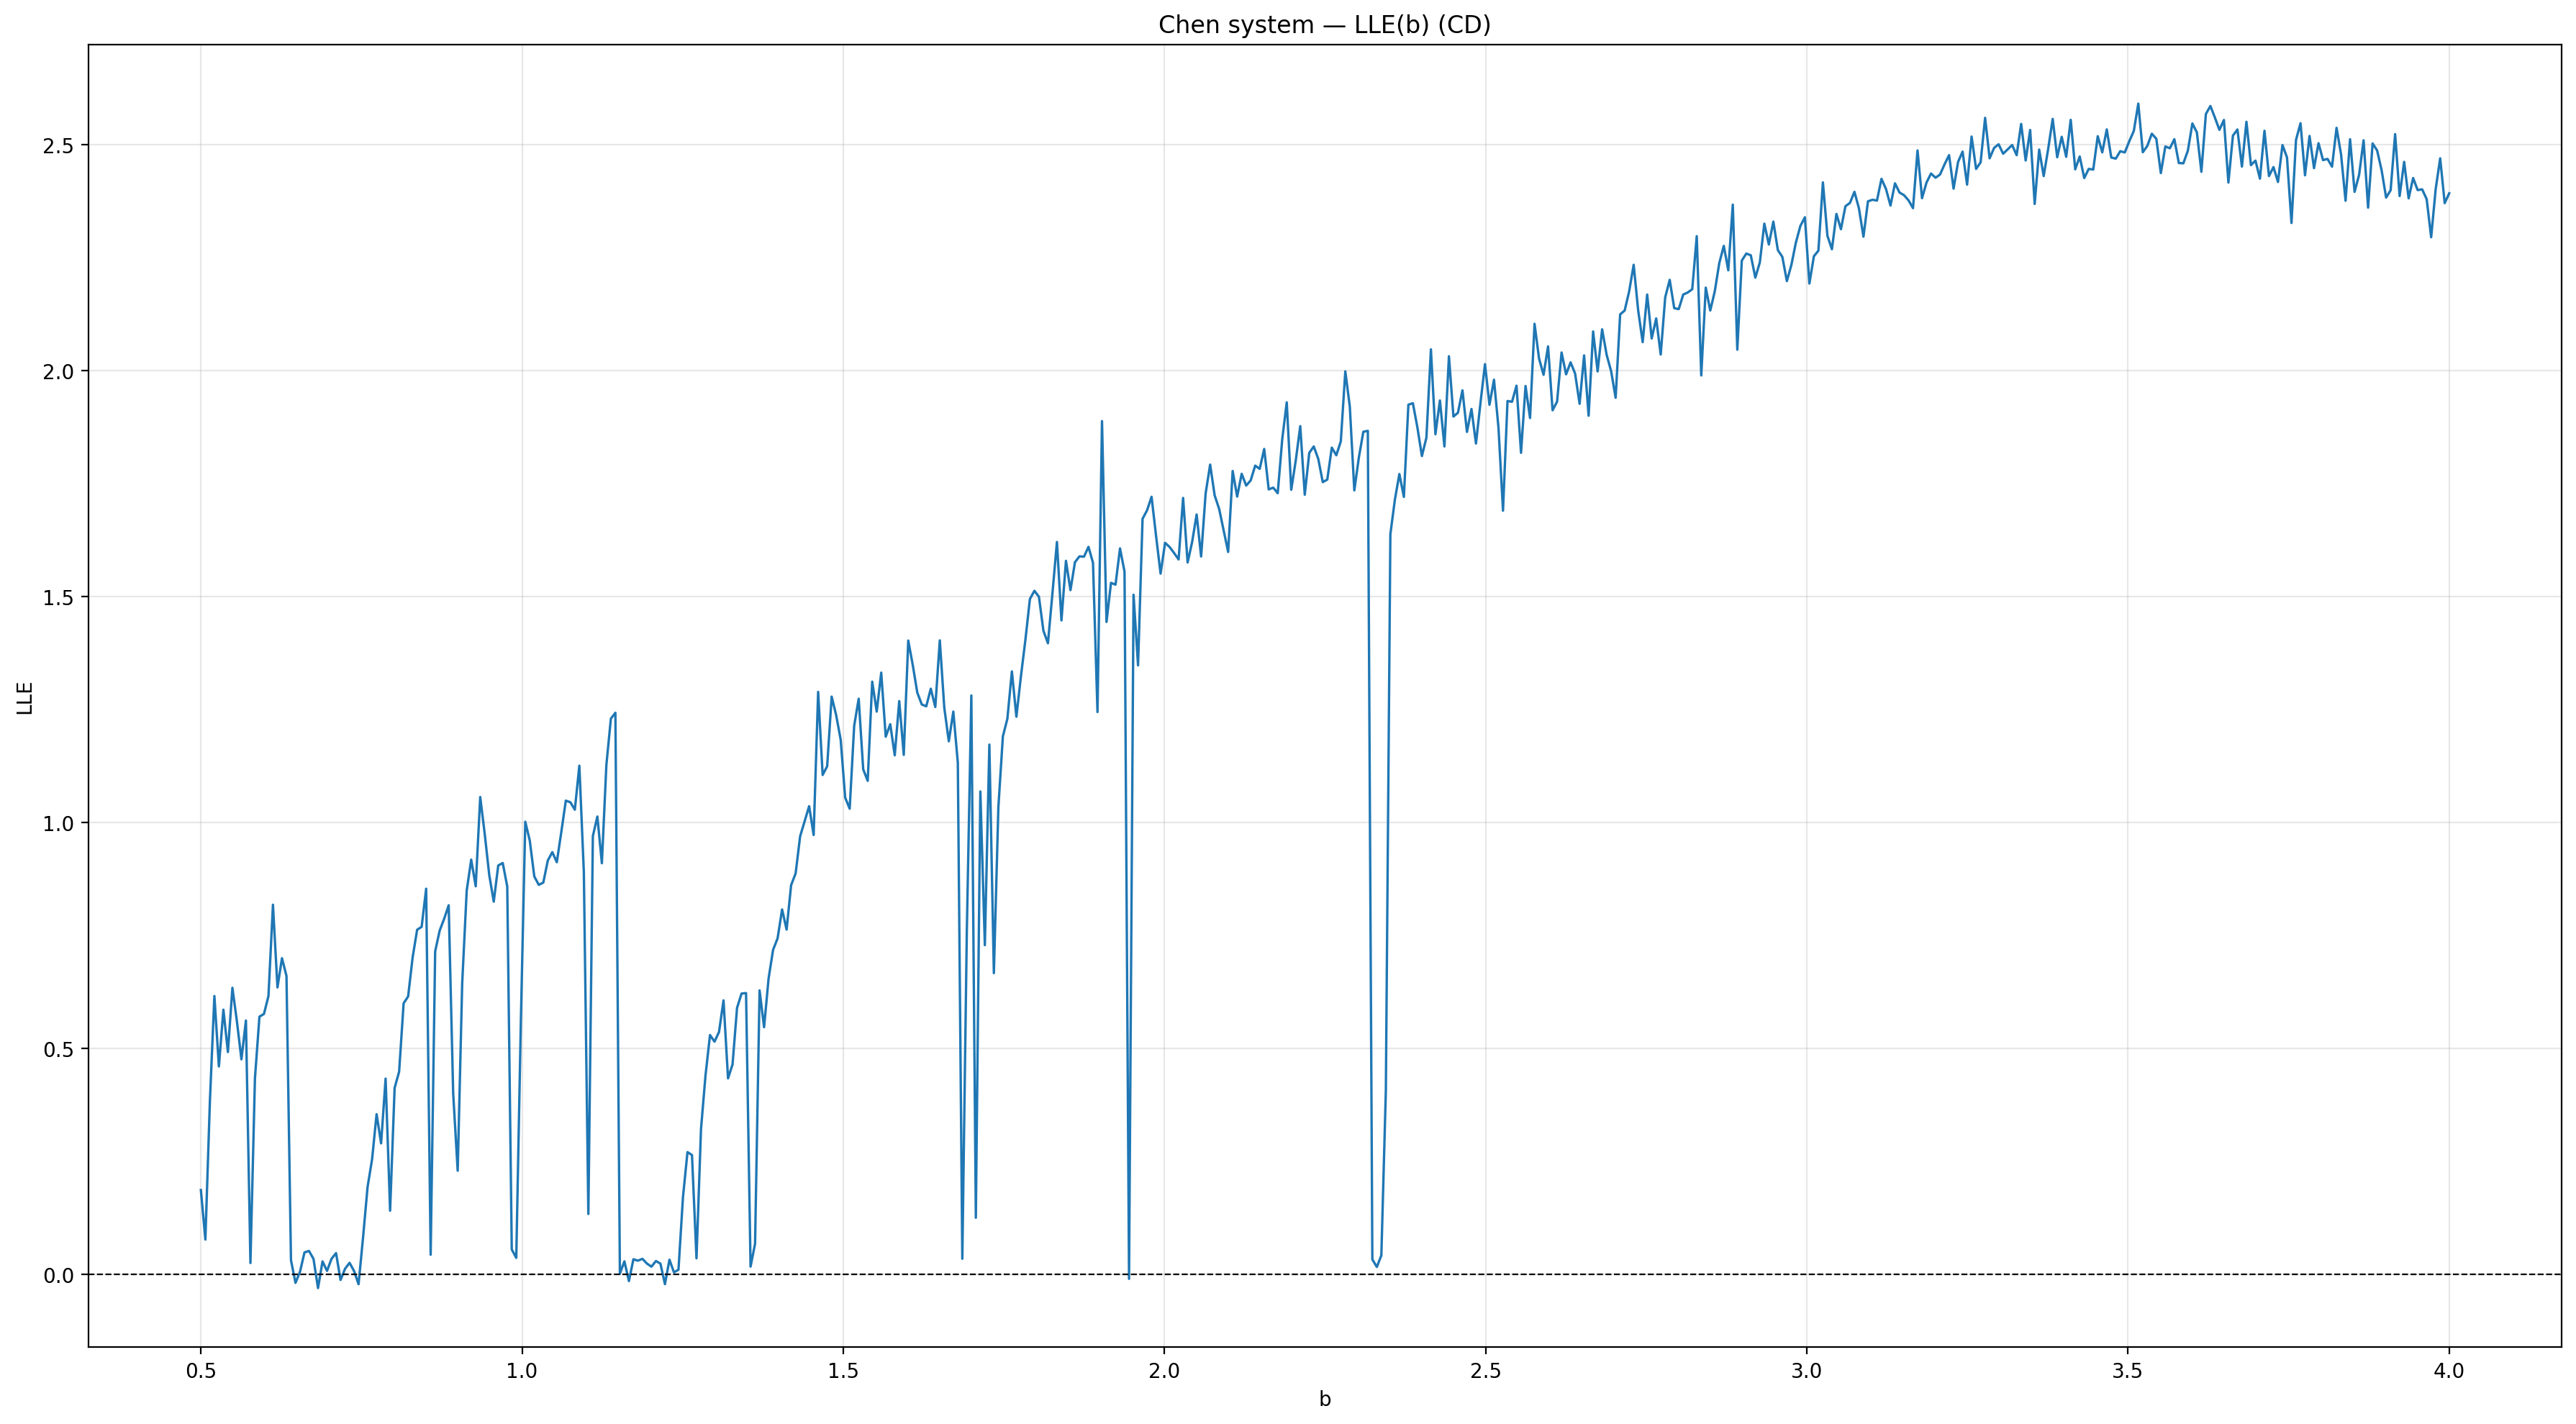

In [ ]:
params, LLE = compute_LLE_scan_1d(
    param_name="b",
    p_min=0.5,
    p_max=4.0,
    num=500,
    a_base=40.0,
    b_base=3.0,
    c_base=28.0,
    steps_trans=30000,
    steps_lya=30000
)

plot_LLE_1d(params, LLE, "b")


LLE scan (a): 100%|██████████| 500/500 [03:57<00:00,  2.11it/s]


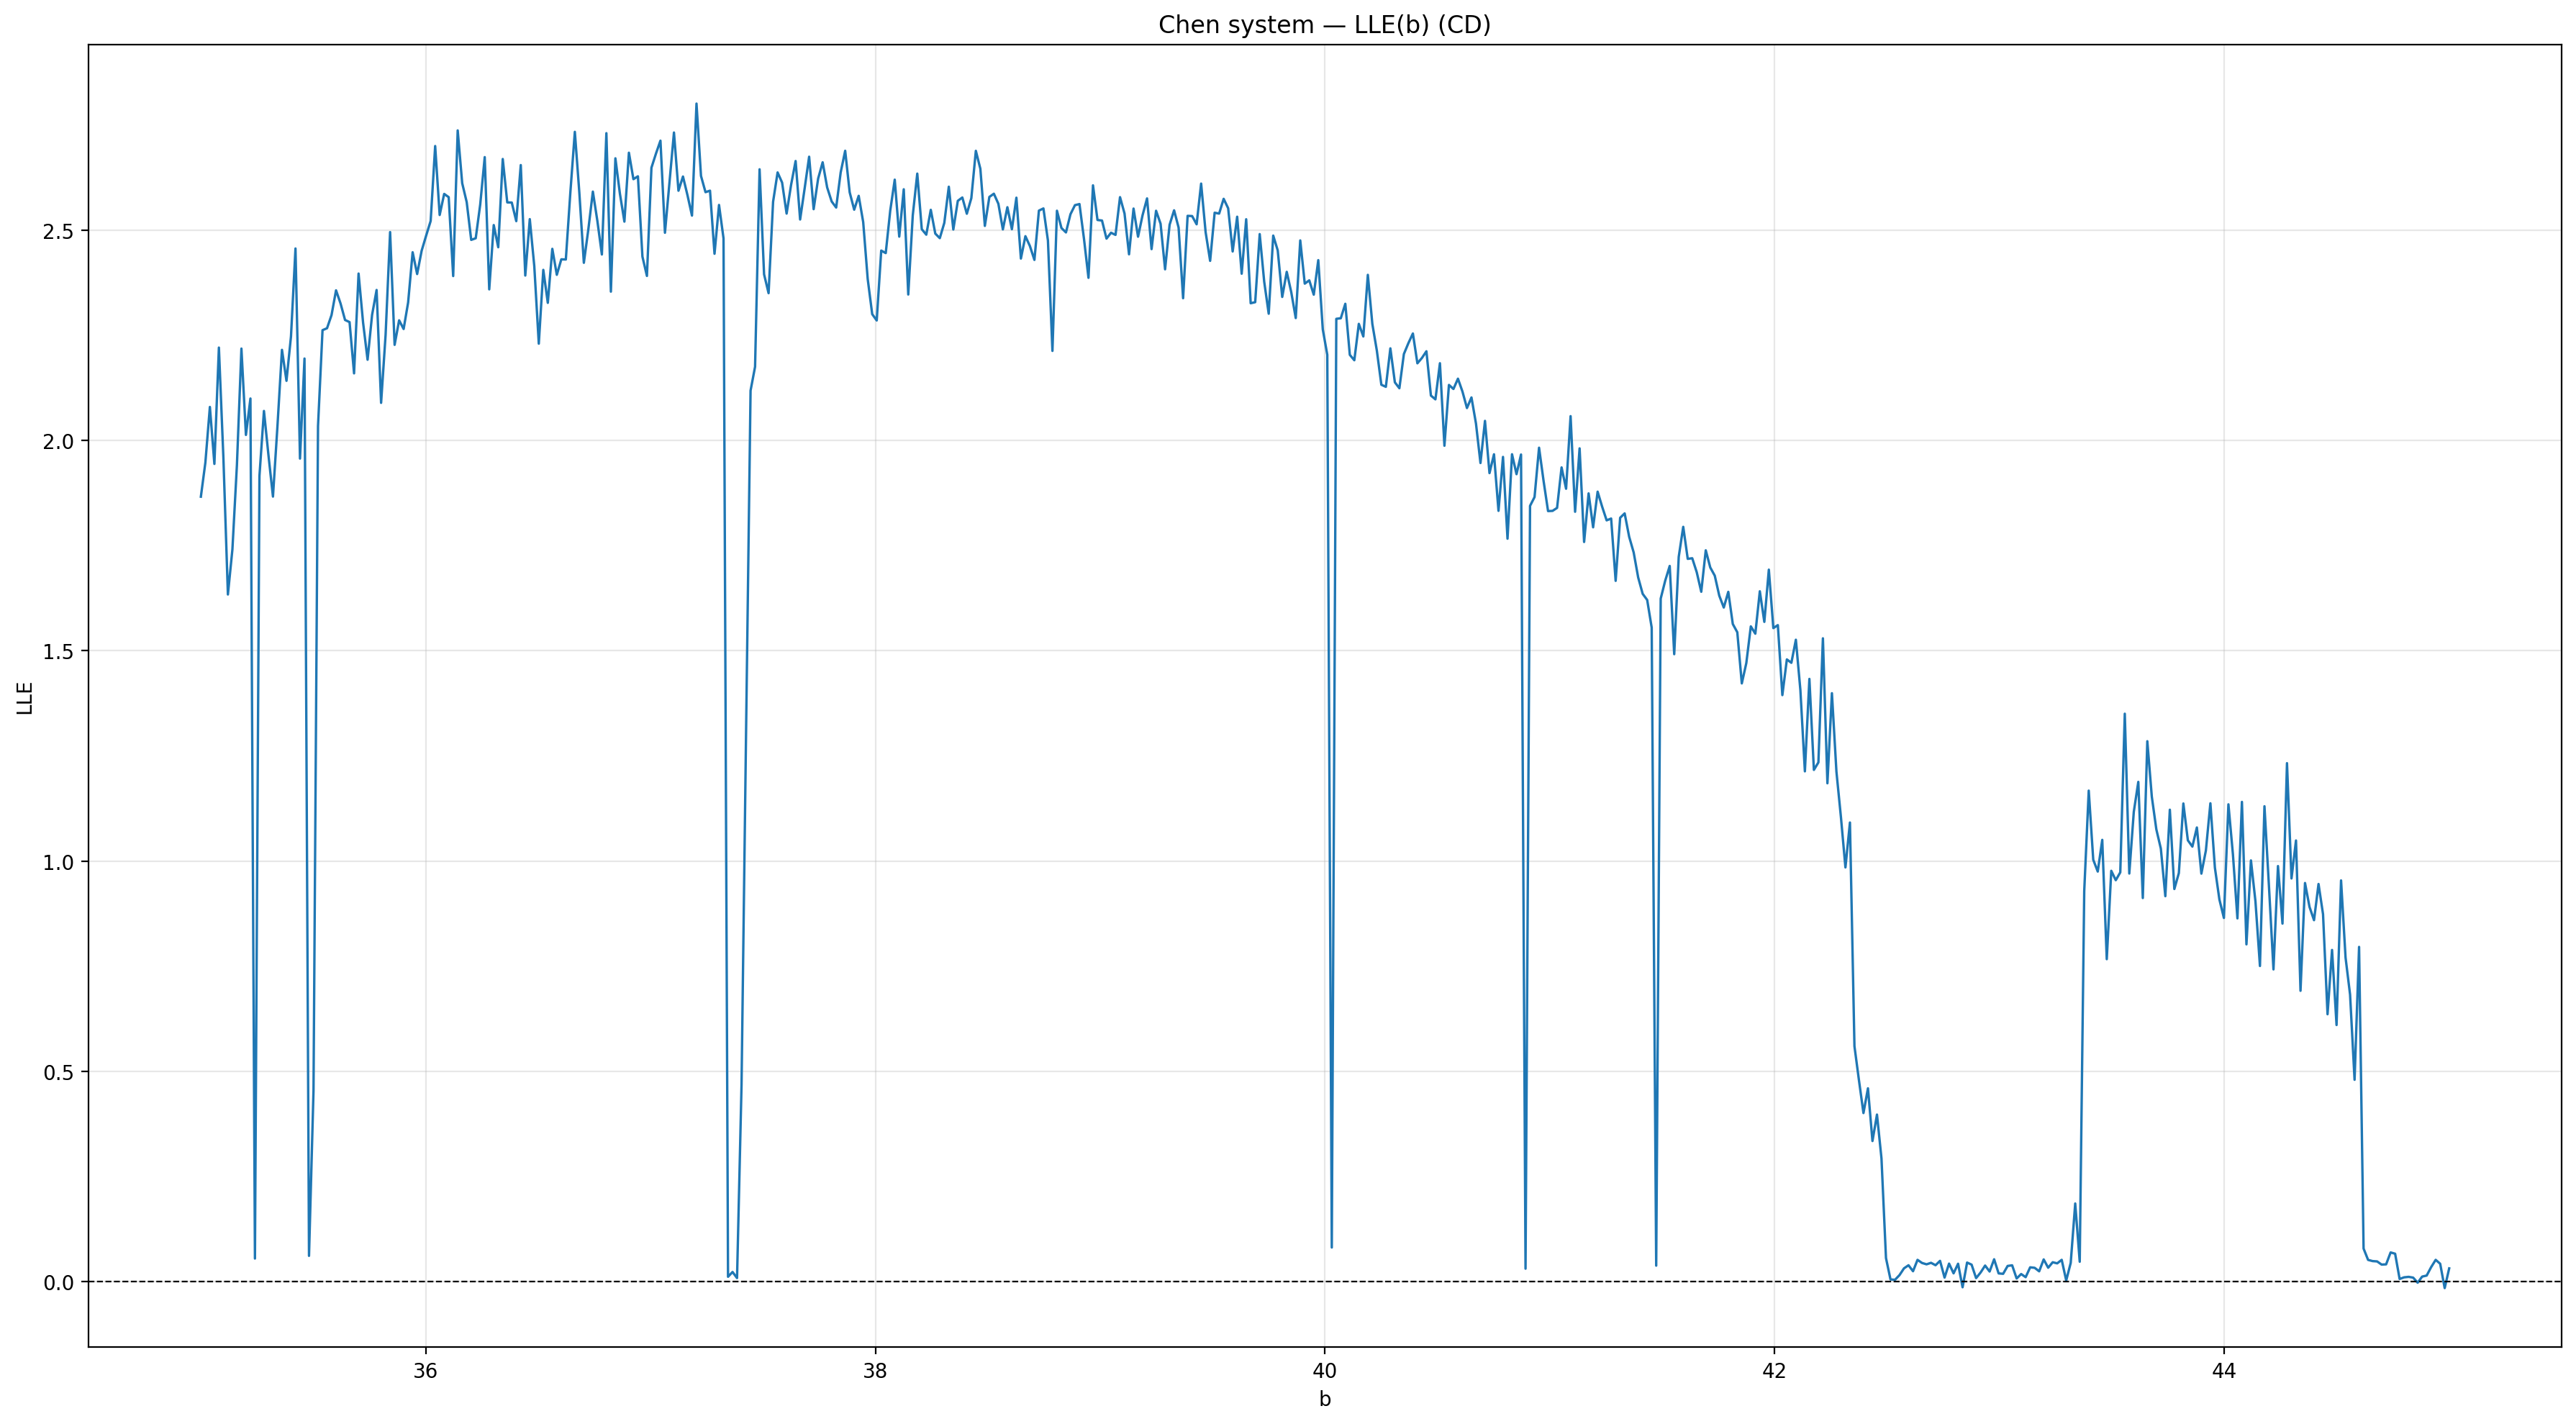

In [ ]:
params, LLE = compute_LLE_scan_1d(
    param_name="a",
    p_min=35.0,
    p_max=45.0,
    num=500,
    a_base=40.0,
    b_base=3.0,
    c_base=28.0,
    steps_trans=30000,
    steps_lya=30000
)


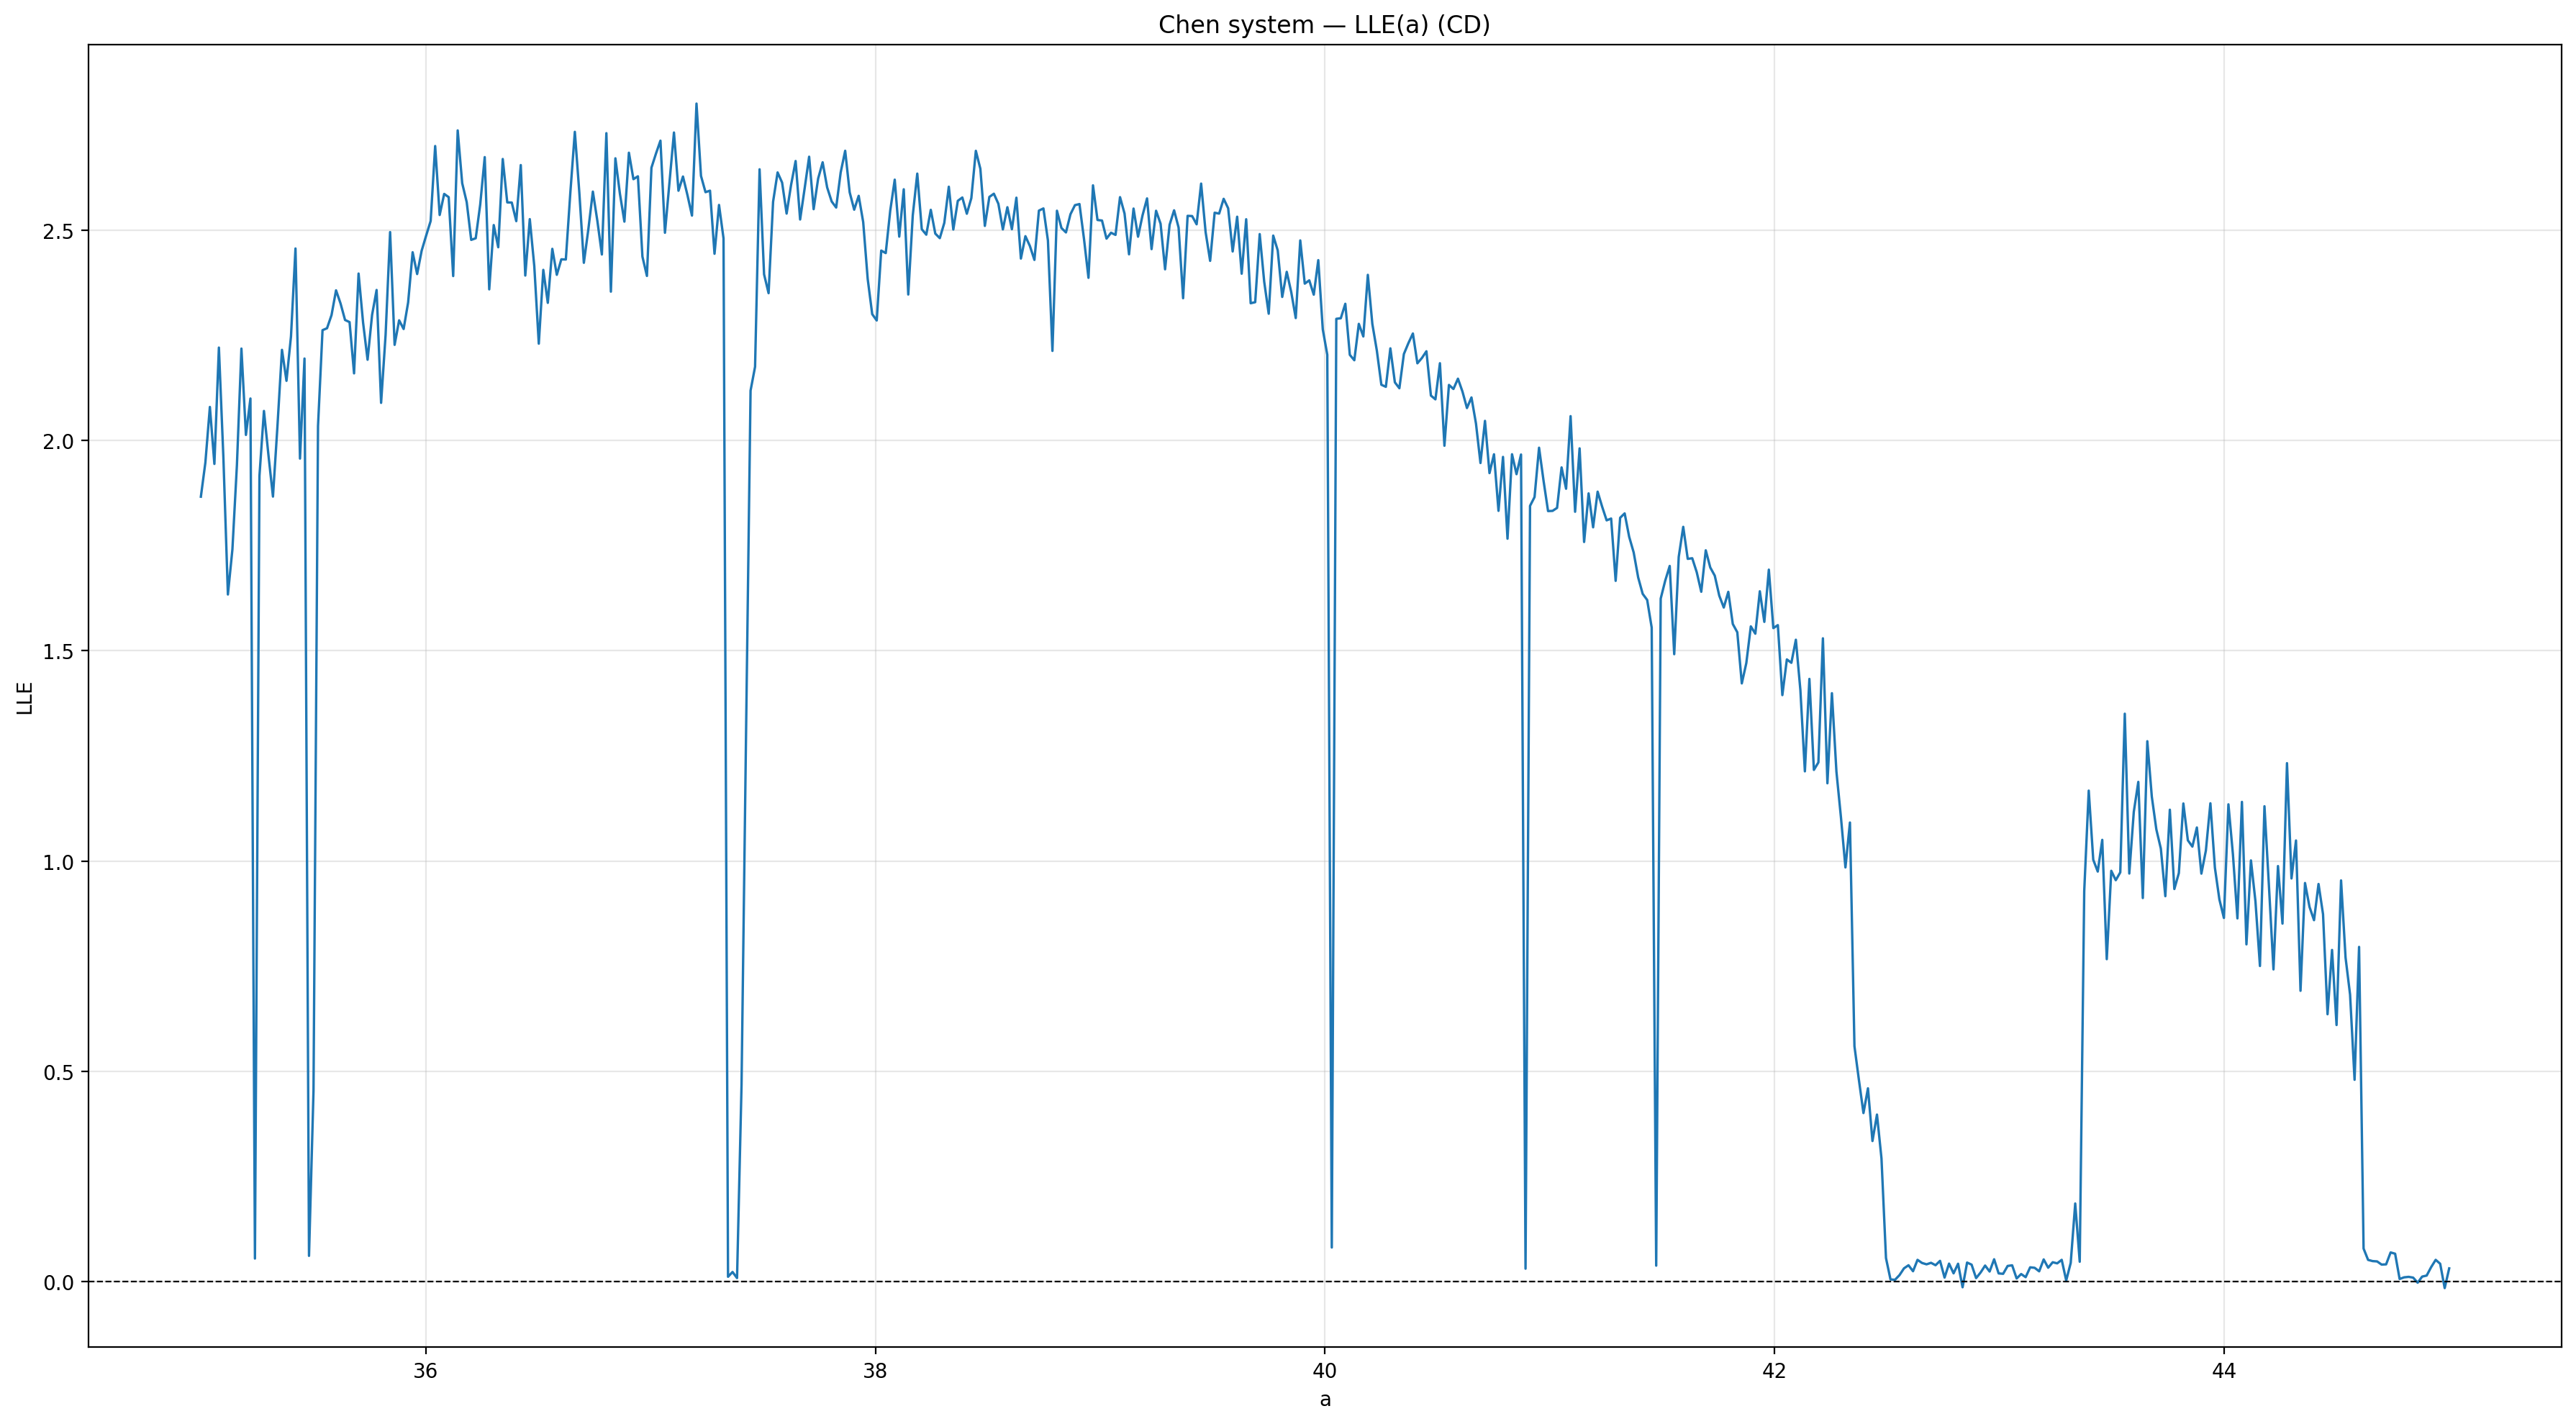

In [ ]:
plot_LLE_1d(params, LLE, "a")

LLE scan (c): 100%|██████████| 500/500 [03:43<00:00,  2.24it/s]


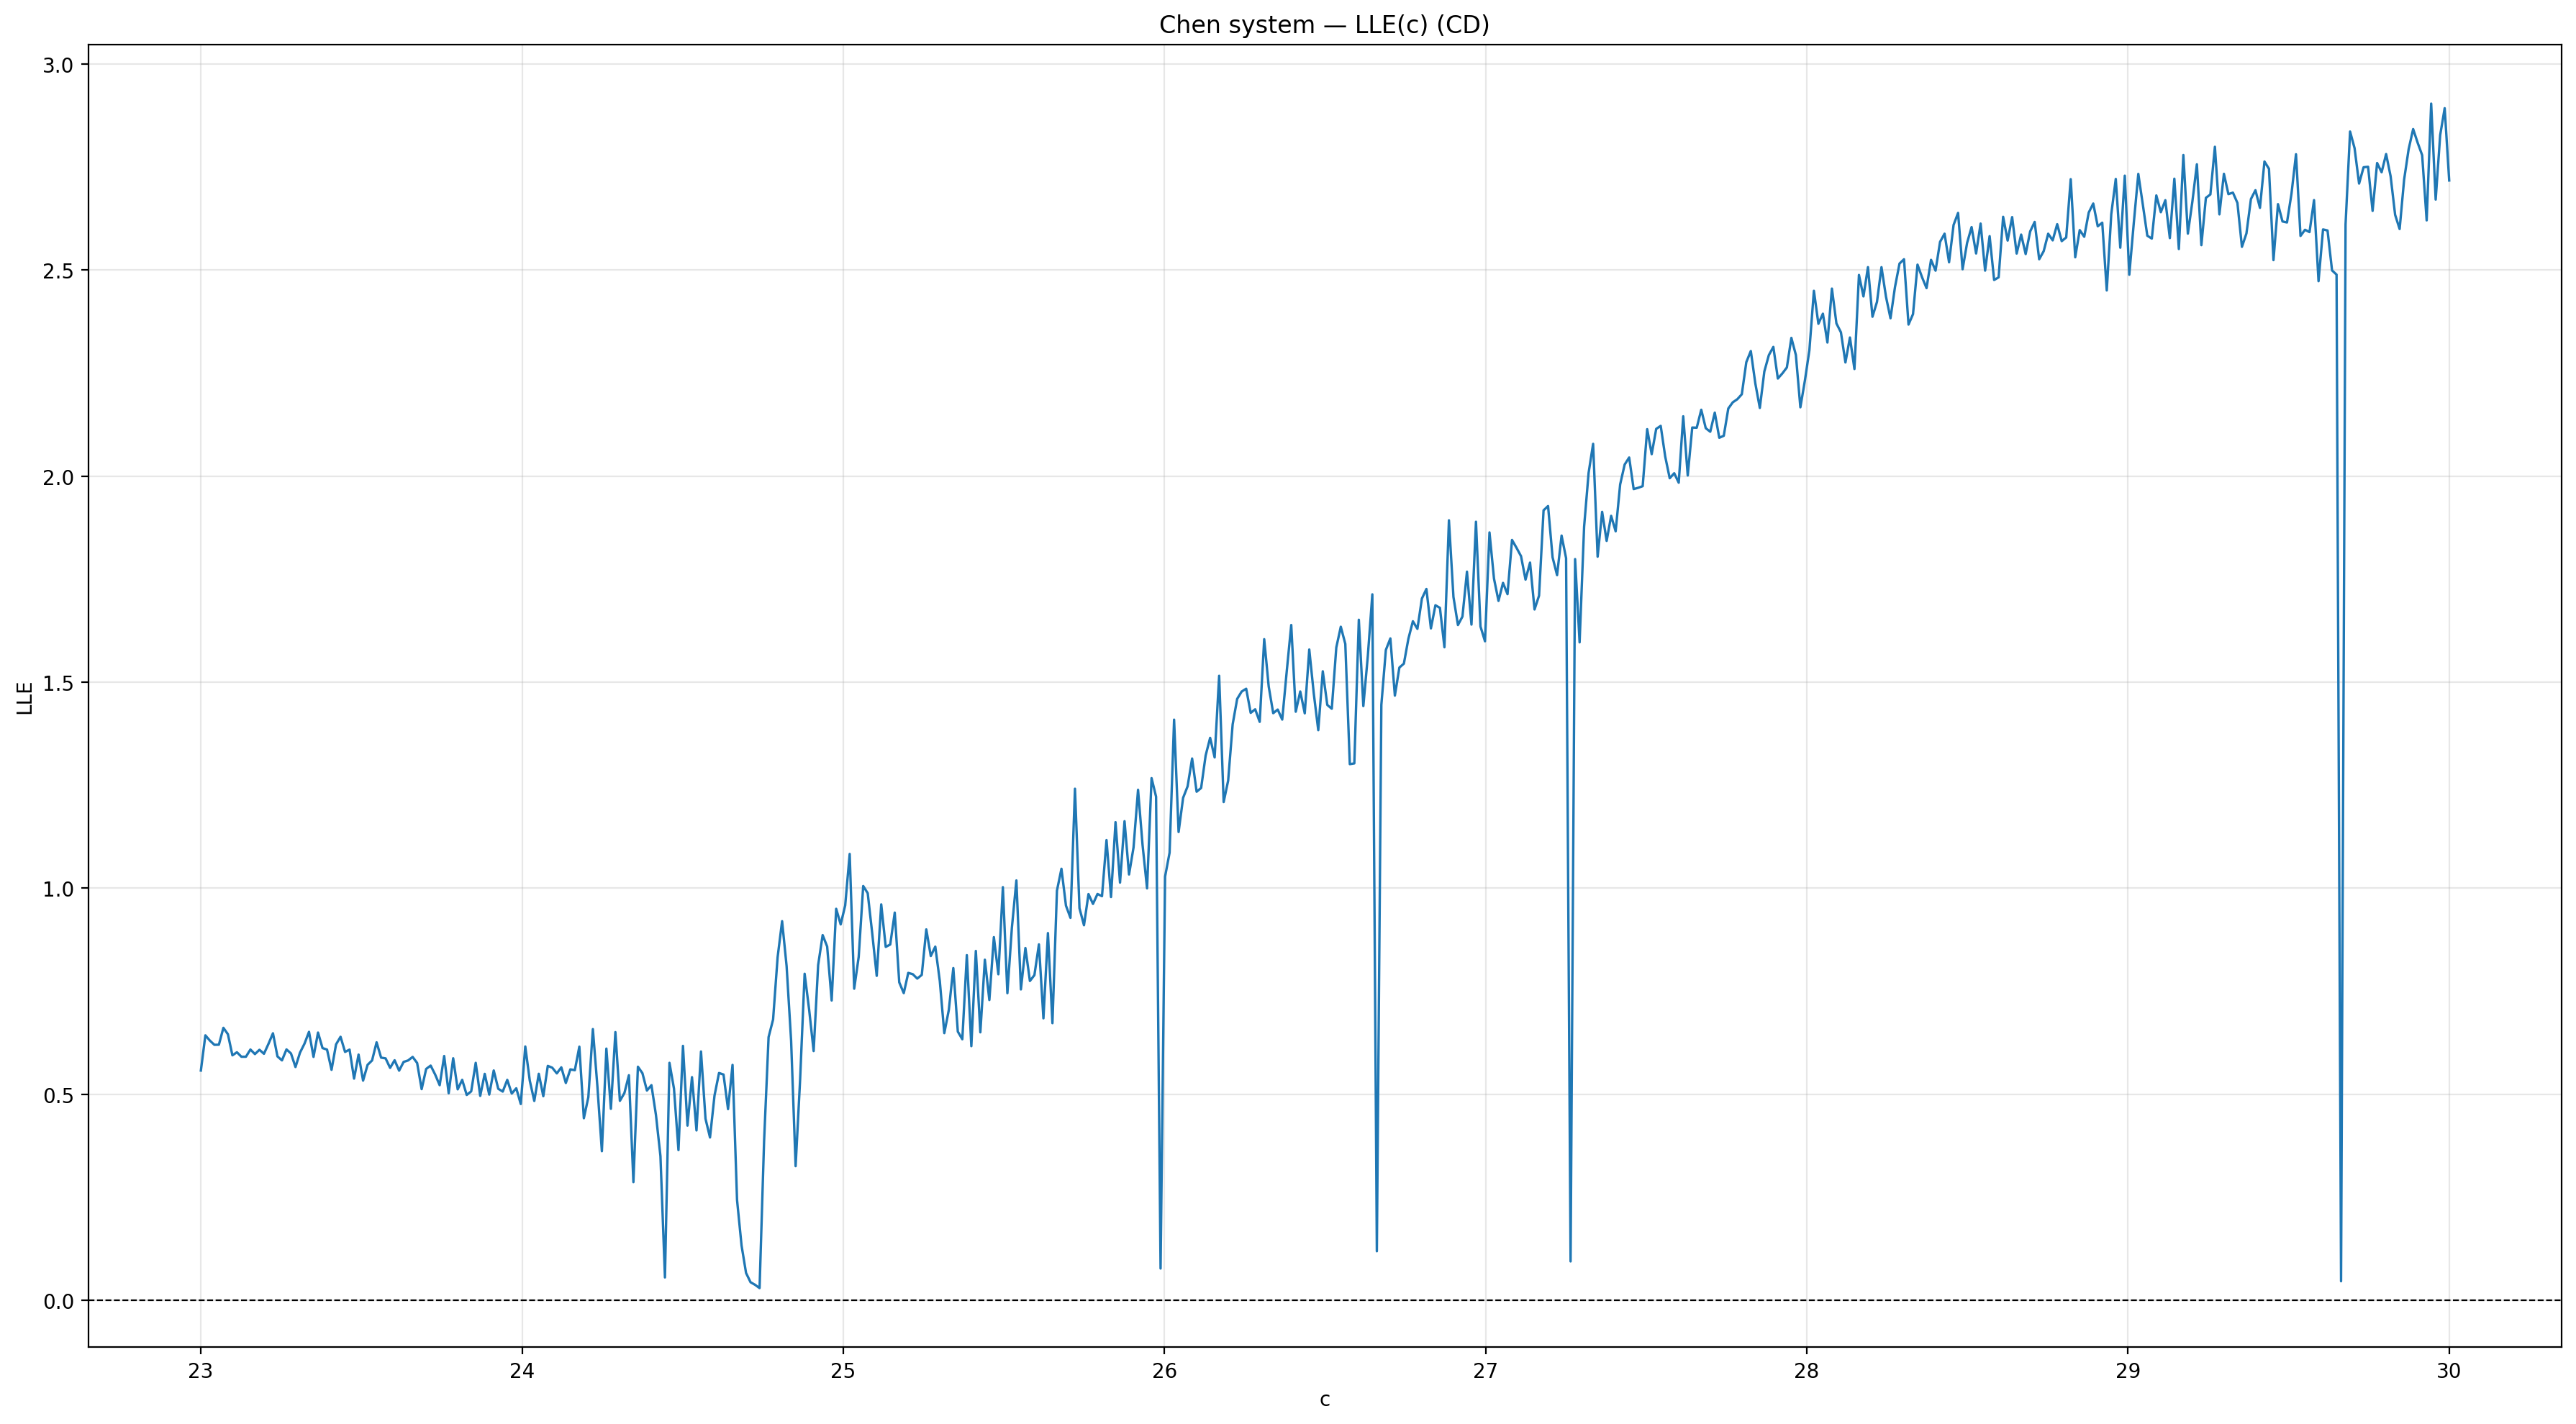

In [ ]:
params, LLE = compute_LLE_scan_1d(
    param_name="c",
    p_min=23.0,
    p_max=30.0,
    num=500,
    a_base=40.0,
    b_base=3.0,
    c_base=28.0,
    steps_trans=30000,
    steps_lya=30000
)

plot_LLE_1d(params, LLE, "c")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def cd_step(state, a, b, c, h=0.0025):
    x0, y0, z0 = state
    hh = h / 2

    # D1
    x1 = (x0 + hh * a * y0) / (1 + hh * a)
    y1 = (y0 + hh * ((c - a) * x1 - x1 * z0)) / (1 - hh * c)
    z1 = (z0 + hh * x1 * y1) / (1 + hh * b)

    # D2
    z2 = z1 + hh * (x1 * y1 - b * z1)
    y2 = y1 + hh * ((c - a) * x1 - x1 * z2 + c * y1)
    x2 = x1 + hh * a * (y2 - x1)

    return np.array([x2, y2, z2])


# ============================================================
# LLE через метод отклонения (CUDA-логика)
# ============================================================
def compute_LLE_cd(a, b, c,
                   dt=0.0025,
                   steps_trans=20000,
                   steps_lya=20000,
                   r=1e-6,
                   L=20):

    # --- транзиент ---
    x = np.array([1.0, 1.0, 1.0])
    for _ in range(steps_trans):
        x = cd_step(x, a, b, c, dt)

    # истинная траектория
    true_traj = np.zeros((steps_lya, 3))
    true_traj[0] = x
    for i in range(1, steps_lya):
        true_traj[i] = cd_step(true_traj[i-1], a, b, c, dt)

    # отклонённая траектория
    x_def = true_traj[0].copy()
    x_def[0] += r  # дефлект по x

    lle_sum = 0.0
    count = 0

    for s in range(1, steps_lya):
        x_def = cd_step(x_def, a, b, c, dt)

        if s % L == 0:
            diff = true_traj[s] - x_def
            norm = np.linalg.norm(diff)

            if norm > 0:
                growth = norm / r
                lle_sum += np.log(growth)
                count += 1

                # ресет отклонения
                x_def = true_traj[s] + diff / growth

    # нормировка по ФИЗИЧЕСКОМУ ВРЕМЕНИ
    total_time = count * L * dt
    return lle_sum / total_time


# ============================================================
# 2D карта LLE
# ============================================================
def lle_2d_map(p1_name, p2_name,
               ranges,
               steps=180,
               dt=0.0025,
               steps_trans=20000,
               steps_lya=20000):

    p1_vals = np.linspace(*ranges[p1_name], steps)
    p2_vals = np.linspace(*ranges[p2_name], steps)

    lle_map = np.zeros((steps, steps))

    for i, p1 in tqdm(enumerate(p1_vals), total=steps, desc=f"{p1_name} sweep"):
        for j, p2 in enumerate(p2_vals):

            a, b, c = 40.0, 3.0, 28.0

            if p1_name == 'a': a = p1
            if p1_name == 'b': b = p1
            if p1_name == 'c': c = p1

            if p2_name == 'a': a = p2
            if p2_name == 'b': b = p2
            if p2_name == 'c': c = p2

            try:
                lle_map[j, i] = compute_LLE_cd(
                    a, b, c,
                    dt=dt,
                    steps_trans=steps_trans,
                    steps_lya=steps_lya
                )
            except:
                lle_map[j, i] = np.nan

    return p1_vals, p2_vals, lle_map


a sweep: 100%|██████████| 88/88 [1:00:14<00:00, 41.07s/it]


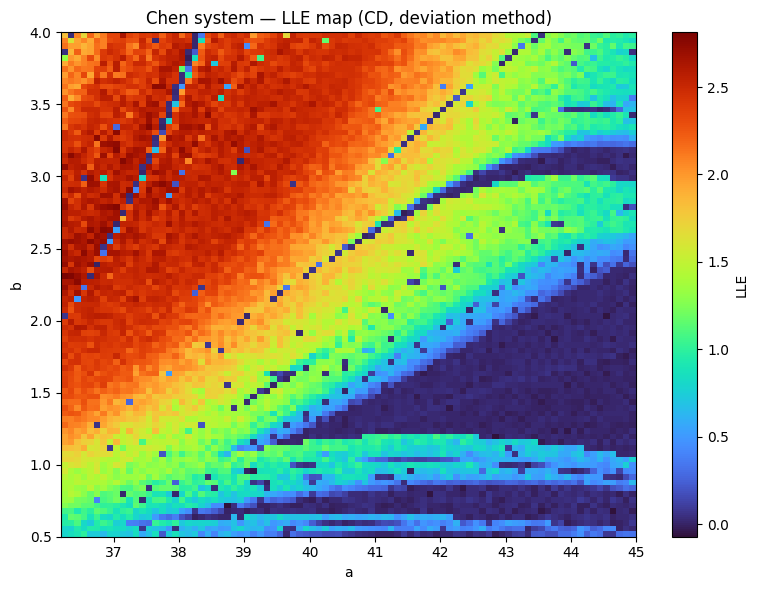

In [ ]:
# ============================================================
# Запуск
# ============================================================
if __name__ == "__main__":

    ranges = {
        'a': (35.0, 45.0),
        'b': (0.5, 4.0),
        'c': (23.0, 30.0)
    }

    ranges['c'] = (23.8, 30.0)
    ranges['a'] = (36.2, 45.0)

    p1, p2, lle = lle_2d_map(
        'a', 'b',
        ranges=ranges,
        steps=88,
        dt=0.0025,
        steps_trans=30000,
        steps_lya=30000
    )

    plt.figure(figsize=(8, 6))
    im = plt.imshow(
        lle,
        extent=[p1.min(), p1.max(), p2.min(), p2.max()],
        origin='lower',
        aspect='auto',
        cmap='turbo'
    )
    plt.colorbar(im, label="LLE")
    plt.xlabel("a")
    plt.ylabel("b")
    plt.title("Chen system — LLE map (CD, deviation method)")
    plt.tight_layout()
    plt.show()
